In [1]:
!pip install pandas psycopg2-binary sqlalchemy matplotlib

In [2]:
import pandas as pd
import psycopg2 as db
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

In [3]:
db_type = 'postgresql'
host = 'database'
port = 5432
db_name = os.environ.get('POSTGRES_DB')
user = os.environ.get('POSTGRES_USER')
password = os.environ.get('POSTGRES_PASSWORD')

conn_uri = f"{db_type}://{user}:{password}@{host}:{port}/{db_name}"
alchemyEngine = create_engine(conn_uri)
db_conn = alchemyEngine.connect();

<Axes: title={'center': 'Customer per day'}, xlabel='date', ylabel='number of customers'>

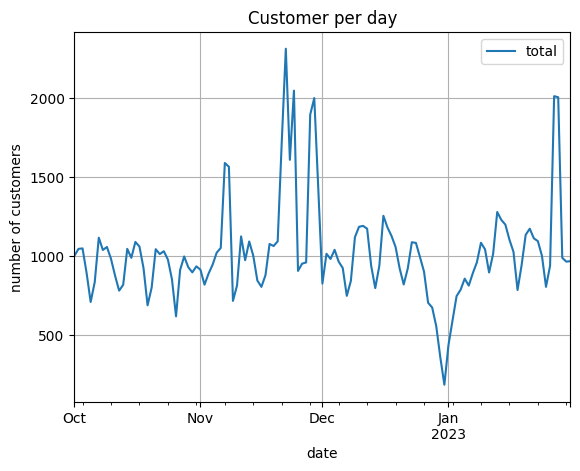

In [5]:
""" Plot Number of customers per day """
db_conn = alchemyEngine.connect();
query = """
    SELECT event_time::DATE as date, COUNT(DISTINCT user_id) as total
    FROM customers
    WHERE event_time between '2022-10-01' AND '2023-02-28'
        AND event_type = 'purchase'
    GROUP BY event_time::DATE
    ORDER BY event_time::DATE ASC
"""
df = pd.read_sql(query, db_conn)
df['date'] = pd.to_datetime(df['date'])
df.head()
df.plot(
    x = 'date',
    y = 'total',
    title="Customer per day",
    xlabel="date",
    ylabel="number of customers",
    grid=True
)

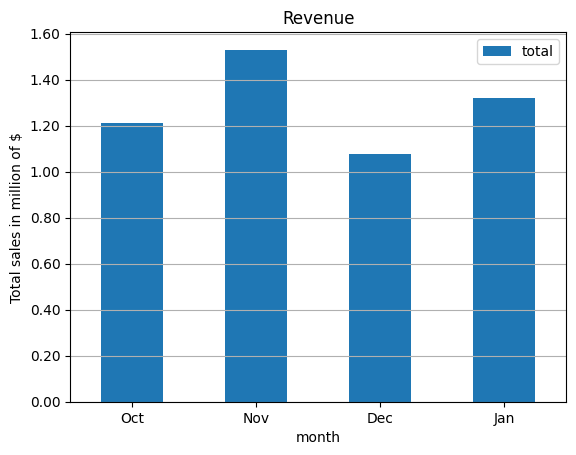

In [6]:
""" Totals sales in million of $ per month """
db_conn = alchemyEngine.connect();
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.2f' % (x * 1e-6)

query = """
    SELECT
        DATE_TRUNC('month', event_time) as month,
        SUM(price) as total
    FROM customers
    WHERE event_time between '2022-10-01' AND '2023-02-28'
        AND event_type = 'purchase'
    GROUP BY DATE_TRUNC('month', event_time)
    ORDER BY month ASC
"""
df = pd.read_sql(query, db_conn)
df['month'] = pd.to_datetime(df['month']).dt.strftime('%b')
# df['month'] = df['month'].dt.strftime('%B')
dp = df.plot(
    kind="bar",
    x="month",
    y="total",
    title="Revenue",
    xlabel="month",
    ylabel="Total sales in million of $",
    rot=0
)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
dp.grid(axis='y')
plt.show()

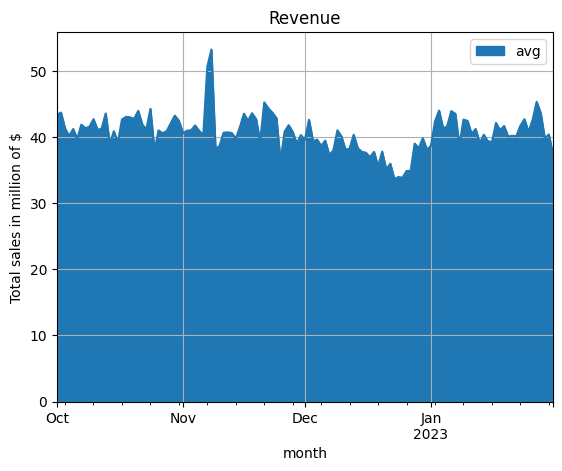

In [8]:
""" Average spend/customers in $ """
db_conn = alchemyEngine.connect();
query = """
    SELECT AVG(purchase) as avg, date
    FROM (
        SELECT
            event_time::date AS date,
            user_id AS uid,
            SUM(price) AS purchase
        FROM customers
        WHERE event_time between '2022-10-01' AND '2023-02-28'
            AND event_type = 'purchase'
        GROUP BY date, user_id
        ORDER BY date ASC
    )
    GROUP BY date
    ORDER BY date ASC
"""
df = pd.read_sql(query, db_conn)
df.head()
df['date'] = pd.to_datetime(df['date'])
dp = df.plot(
    kind="area",
    x="date",
    y="avg",
    title="Revenue",
    xlabel="month",
    ylabel="Total sales in million of $",
    rot=0,
    grid=True
)
plt.show()
